In [1]:
import pandas as pd
import io
import optuna
import numpy as np
import cupy as cp
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['axes.prop_cycle'] 
font = {'family' : 'sans-serif'}
matplotlib.rc('font', **font)
import matplotlib.dates as mdates
import scipy.optimize as sco
import scipy.special as scs
pd.set_option("display.max_columns", 20)

ModuleNotFoundError: ignored

In [2]:
pip install optuna

     |████████████████████████████████| 143kB 10.5MB/s 
     |████████████████████████████████| 1.1MB 25.7MB/s 
     |████████████████████████████████| 81kB 14.3MB/s 
     |████████████████████████████████| 471kB 62.4MB/s 
     |████████████████████████████████| 51kB 9.9MB/s 
     |████████████████████████████████| 112kB 67.8MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
  Created wheel for optuna: filename=optuna-1.1.0-cp36-none-any.whl size=187322 sha256=fb299f168e88feaf5714817e81359812cd69d2d3293970adc88c353f9a3a802a
  Stored in directory: /root/.cache/pip/wheels/b7/25/09/6beaa68d3d3b4ea39b892927d70199ca762b04c72705bcc59e
  Created wheel for alembic: filename=alembic-1.4.0-py2.py3-none-any.whl size=157561 sha256=82932c1b1db5941c908a1b2c2fa21114ed67508d2736969a21410a1af85d110d
  Stored in directory: /root/.cache/pip/wheels/26/5e/30/84097f2b9e8215a03af766c647ac6dbef8f2f522af31e8c192
  Created wheel for Mako: filename=Mako-1.1.1-cp36-none-any.whl size=75410 sha256=fb75599c

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files
uploaded = files.upload()

Saving 10_Industry_Portfolios_Daily.CSV to 10_Industry_Portfolios_Daily.CSV


In [0]:
# read data from Google Drive or Uploaded files
parser = lambda date: pd.to_datetime(date, format='%Y%m%d')

Industry_portfolio_MKT = pd.read_csv("10_Industry_Portfolios_Daily.CSV",index_col=0,parse_dates=True,date_parser=parser)
Industry_portfolio_MKT = Industry_portfolio_MKT/100
Twenty_Five_portfolio = pd.read_csv("/content/drive/My Drive/Colab Notebooks/20191223/25_Portfolios_5x5_Daily.CSV",index_col=0,parse_dates=True,date_parser=parser)
Twenty_Five_portfolio = Twenty_Five_portfolio/100

# MSCI Dataを Returnに変換
Country_MKT = pd.read_excel("/content/drive/My Drive/Colab Notebooks/20191223/MSCI_8_Country_World_Index.xlsx",index_col=0,parse_dates=True)
Country_MKT = Country_MKT.pct_change()
Country_MKT = Country_MKT.fillna(method='bfill')
Country_MKT = Country_MKT.resample('B').last() # Business Day

# 解析区間(時間)を設定 1963-7-1 ~ 2019-10-31
Industry_portfolio_MKT = Industry_portfolio_MKT[Industry_portfolio_MKT.index >= dt.datetime(1963,7,1)]
Twenty_Five_portfolio = Twenty_Five_portfolio[Twenty_Five_portfolio.index >= dt.datetime(1963,7,1)]
Country_MKT = Country_MKT[(Country_MKT.index >= dt.datetime(1995,1,2))&(Country_MKT.index <= dt.datetime(2019,10,31))]
SMB_HML_MKT = Twenty_Five_portfolio[['SMB','HML','Mkt-RF']]
Twenty_Five_portfilio_MKT = Twenty_Five_portfolio.iloc[:,:-3]
Twenty_Five_portfilio_MKT_SMB_HML = Twenty_Five_portfolio.iloc[:,:-1]
Twenty_Five_portfilio_MKT_SMB_HML_UMD = Twenty_Five_portfolio



In [0]:
# datasetにはDataFrameを入れる, windowは年単位, method = ["EW","inv_vol","min_var","max_div","max_SR","min_corr","inv_var","Equal_Risk_Con","min_VaR","min_CVaR"]
def portfolio_optimization(dataset,method,window,beta):
  # In SampleをY年ずつ分ける / Out of Sampleを1か月分ずつ分ける
  Y = window
  M = 12*Y
  dataset_M = dataset.resample('1M').last()
  In_Sample = []
  Out_of_Sample_o =[]
  for i in range(len(dataset_M.index)-M):
    if i==0:
      In_Sample += [dataset.loc[(dataset.index <= dataset_M.index[M-1])]]
      Out_of_Sample_o += [dataset.loc[(dataset.index > dataset_M.index[M+i-1])&(dataset.index <= dataset_M.index[M+i])]]
    else:
      In_Sample += [dataset.loc[(dataset.index > dataset_M.index[i-1])&(dataset.index <= dataset_M.index[M+i-1])]]
      Out_of_Sample_o += [dataset.loc[(dataset.index > dataset_M.index[M+i-1])&(dataset.index <= dataset_M.index[M+i])]]

  #Out-of-Sampleを分ける
  Out_of_Sample = dataset_M[dataset_M.index > dataset_M.index[M-1]]

  #Out-of-Sampleのマンスリー累積リターンを求める
  Out_of_Sample_rets = pd.DataFrame(index=Out_of_Sample.index, columns=Out_of_Sample.columns)
  for i in range(len(Out_of_Sample_rets)):
    Out_of_Sample_rets.iloc[i] = (Out_of_Sample_o[i]+1).prod()-1


  def min_func_var(weights,cov):
    p_std = np.sqrt(weights.T@cov@weights)
    return p_std
  
  def minimum_variance(cov):
    num_assets = len(cov)
        
    args = cov

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # constraintsは、ポジションを全て足すと1、という条件を示す。
        
    bounds = tuple([(0.,1.) for asset in range(num_assets)])
    #  boundsは、それぞれのポジションが0以上1以下であることを示す。
        
    result = sco.minimize(min_func_var, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    #   num_assets*[1./num_assets,] は、計算開始の初期値 (初期weight)
    return result.x

  def neg_diversification_ratio(weights, vol, cov):
    dr = -(weights.T@vol)/ np.sqrt(weights.T@cov@weights)
    return dr

  def maximum_diversification_ratio(vol, cov):
    num_assets = len(cov)
        
    args = vol, cov

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # constraintsは、ポジションを全て足すと1、という条件を示す。
        
    bounds = tuple([(0.,1.) for asset in range(num_assets)])
    #  boundsは、それぞれのポジションが0以上1以下であることを示す。
        
    result = sco.minimize(neg_diversification_ratio, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    #   num_assets*[1./num_assets,] は、計算開始の初期値 (初期weight) 
    return result.x

  def portfolio_annualised_performance(weights, mean_rets, cov):
    ret = np.sum(mean_rets * weights) * 12
    std = np.sqrt(weights.T@cov@weights)
    return std, ret

  def neg_sharpe_ratio(weights, mean_rets, cov):
    p_std, p_ret = portfolio_annualised_performance(weights, mean_rets, cov)
    return -(p_ret) / p_std

  def max_sharpe_ratio(mean_rets, cov): #0
    if (mean_rets > 0.).sum() == 0: return np.zeros(len(mean_rets))
    # ↑は、もし全ての資産のリターンがマイナスなら投資すべきではない、という意味。  
    else:
      num_assets, args = len(mean_rets), (mean_rets, cov)
      # argsは下のscoで最適化する際に固定する変数。
        
      constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
      # constraintsは、ポジションを全て足すと1、という条件を示す。
        
      bounds = tuple([(0.,1.) for asset in range(num_assets)])
      #  boundsは、それぞれのポジションが0以上1以下であることを示す。
        
      result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,],args=args, method='SLSQP', bounds=bounds, constraints=constraints)
      #   num_assets*[1./num_assets,] は、計算開始の初期値 (初期weight) 
      return result.x


  def neg_correlation_ratio(weights, cor):
    dr = -1/ (np.sqrt(weights.T@cor@weights))
    return dr

  def minimum_correlatiom_ratio(cor):
    num_assets = len(cor)
        
    args = (cor)

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # constraintsは、ポジションを全て足すと1、という条件を示す。
        
    bounds = tuple([(0.,1.) for asset in range(num_assets)])
    #  boundsは、それぞれのポジションが0以上1以下であることを示す。
        
    result = sco.minimize(neg_correlation_ratio, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    #   num_assets*[1./num_assets,] は、計算開始の初期値 (初期weight) 
    return result.x

  def risk_budget_objective(w,cov):
  # calculate portfolio risk
    weights = np.array(w)
    sigma = np.sqrt(weights.T@cov@weights)
    MRC = (cov@weights)/sigma
    RC = np.array(weights*MRC)
    a = np.reshape(RC,(len(RC),1))
    risk_diffs= a - a.T
    sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
    return sum_risk_diffs_squared

  def equal_risk_contribution(cov):
    num_assets = len(cov)
    # argsは下のscoで最適化する際に固定する変数。
    x0 = np.diag(cov)
    args = cov
    options = {'ftol': 1e-20, 'maxiter': 800}      
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # constraintsは、ポジションを全て足すと1、という条件を示す。      
    bounds = tuple([(0.,1.) for asset in range(num_assets)])
    #  boundsは、それぞれのポジションが0以上1以下であることを示す。
    result= sco.minimize(risk_budget_objective,x0=x0, args=args, method='SLSQP',bounds=bounds,constraints=constraints,options=options)
    return result.x

  def Calculate_VaR(w,mean_rets,cov,beta):
    p_std, p_ret = portfolio_annualised_performance(w, mean_rets, cov)
    VaR = p_ret + np.sqrt(2)*scs.erfinv(2*beta-1)*p_std
    return VaR

  def minimize_VaR(mean_rets,cov,beta):
    num_assets, args = len(mean_rets), (mean_rets, cov, beta)
    # argsは下のscoで最適化する際に固定する変数。
        
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # constraintsは、ポジションを全て足すと1、という条件を示す。
        
    bounds = tuple([(0.,1.) for asset in range(num_assets)])
    #  boundsは、それぞれのポジションが0以上1以下であることを示す。
        
    result = sco.minimize(Calculate_VaR, num_assets*[1./num_assets,],args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    #   num_assets*[1./num_assets,] は、計算開始の初期値 (初期weight) 
    return result.x
  
  def Calculate_CVaR(w,mean_rets,cov,beta):
    p_std, p_ret = portfolio_annualised_performance(w, mean_rets, cov)
    CVaR = p_ret + ((np.sqrt(2)*np.exp(scs.erfinv(2*beta-1)**2)*(1-beta))**-1)*p_std
    return CVaR

  def minimize_CVaR(mean_rets,cov,beta):
    num_assets, args = len(mean_rets), (mean_rets, cov, beta)
    # argsは下のscoで最適化する際に固定する変数。
        
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # constraintsは、ポジションを全て足すと1、という条件を示す。
        
    bounds = tuple([(0.,1.) for asset in range(num_assets)])
    #  boundsは、それぞれのポジションが0以上1以下であることを示す。
        
    result = sco.minimize(Calculate_CVaR, num_assets*[1./num_assets,],args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    #   num_assets*[1./num_assets,] は、計算開始の初期値 (初期weight) 
    return result.x

  if "min_VaR" == method:
    min_VaR_rets = pd.DataFrame(index=Out_of_Sample_rets.index, columns=['Minimum VaR'])
    for i in range(len(min_VaR_rets)):
        a = Out_of_Sample_rets.iloc[i,:]
        b = minimize_VaR(In_Sample[i].mean(),In_Sample[i].cov(),beta)
        min_VaR_rets.iloc[i] = a.dot(b)    
    return min_VaR_rets   

  if "min_CVaR" == method:
    min_CVaR_rets = pd.DataFrame(index=Out_of_Sample_rets.index, columns=['Minimum CVaR'])
    for i in range(len(min_CVaR_rets)):
        a = Out_of_Sample_rets.iloc[i,:]
        b = minimize_CVaR(In_Sample[i].mean(),In_Sample[i].cov(),beta)
        min_CVaR_rets.iloc[i] = a.dot(b)    
    return min_CVaR_rets 


  if "max_SR" == method:
    max_SR_rets = pd.DataFrame(index=Out_of_Sample_rets.index, columns=['Max Sharpe Ratio'])
    for i in range(len(max_SR_rets)):
      a = Out_of_Sample_rets.iloc[i,:]
      b = max_sharpe_ratio(In_Sample[i].mean(),In_Sample[i].cov())
      max_SR_rets.iloc[i] = a.dot(b)    
    return max_SR_rets

  if "max_div" == method: 
    max_div_rets = pd.DataFrame(index=Out_of_Sample_rets.index, columns=['Maximum Diversification'])
    for i in range(len(max_div_rets)):
      a = Out_of_Sample_rets.iloc[i,:]
      b = maximum_diversification_ratio(In_Sample[i].std(),In_Sample[i].cov())
      max_div_rets.iloc[i] = a.dot(b)
    return max_div_rets

  if "EW" == method: 
    EW_rets = Out_of_Sample_rets.mean(axis=1)
    EW_df = pd.DataFrame(data=EW_rets, columns=['Equal Weight'])
    #print('EW!!!!')
    return EW_df

  if "min_var" == method:
    min_var_rets = pd.DataFrame(index=Out_of_Sample_rets.index, columns=['Minimum Variance'])
    for i in range(len(min_var_rets)):
      a = Out_of_Sample_rets.iloc[i,:]
      b = minimum_variance(In_Sample[i].cov())
      min_var_rets.iloc[i] = a.dot(b)
    return min_var_rets

  if "inv_vol" == method:
    IV_rets = pd.DataFrame(index=Out_of_Sample_rets.index, columns=['Inverse Volatility'])
    for i in range(len(IV_rets)):
      a = Out_of_Sample_rets.iloc[i,:] 
      b = In_Sample[i].std().pow(-1).div(In_Sample[i].std().pow(-1).sum())
      IV_rets.iloc[i] = a.dot(b)
      #print("inv vol!!!")
    return IV_rets

  if "inv_var" == method: 
    IVar_rets = pd.DataFrame(index=Out_of_Sample_rets.index, columns=['Inverse Variance'])
    for i in range(len(IVar_rets)):
      a = Out_of_Sample_rets.iloc[i,:] 
      b = In_Sample[i].var().pow(-1).div(In_Sample[i].var().pow(-1).sum())
      IVar_rets.iloc[i] = a.dot(b)
    return IVar_rets

  if "min_corr" == method: 
    min_corr_rets = pd.DataFrame(index=Out_of_Sample_rets.index, columns=['Minimum Correlation'])
    for i in range(len(min_corr_rets)):
      a = Out_of_Sample_rets.iloc[i,:]
      b = minimum_correlatiom_ratio(In_Sample[i].corr())
      min_corr_rets.iloc[i] = a.dot(b)   
    return min_corr_rets

  if "Equal_Risk_Con" == method: 
    Equal_Risk_Con_rets = pd.DataFrame(index=Out_of_Sample_rets.index, columns=['Equal Risk Contribution'])
    for i in range(len(Equal_Risk_Con_rets)):
      a = Out_of_Sample_rets.iloc[i,:]
      b = equal_risk_contribution(In_Sample[i].cov())
      Equal_Risk_Con_rets.iloc[i] = a.dot(b)   
    return Equal_Risk_Con_rets

  

In [0]:
def index_plot(dataset):
  dataset_index = dataset.copy()
  dataset_index.iloc[0] = 100*(dataset.iloc[0]+1)
  for i in range(1,len(dataset_index)) :
    dataset_index.iloc[i]=(dataset_index.iloc[i]+1)*dataset_index.iloc[i-1]
  dataset_plot = dataset.plot()
  dataset_plot.set_xlabel("Time")
  dataset_plot.set_ylabel("Return")

  dataset_index_plot = dataset_index.plot()
  dataset_index_plot.set_xlabel("Time")
  dataset_index_plot.set_ylabel("Index")
  
  return dataset_plot, dataset_index_plot, dataset_index

In [0]:
#portfolio_optimization(Twenty_Five_portfilio_MKT_SMB_HML,"max_div",2,0.99)
#method = ["EW","inv_vol","min_var","max_div","max_SR","min_corr","inv_var","Equal_Risk_Con","min_VaR","min_CVaR"]
#sampler(Twenty_Five_portfilio_MKT,3)
result(Twenty_Five_portfilio_MKT_SMB_HML,2,0.99)

EW
inv_vol
min_var
max_div
max_SR
min_corr
inv_var
Equal_Risk_Con
min_VaR
min_CVaR


In [0]:
# Create graphs with different portfolio optimization methods and give you stats
def result(dataset,Y,beta):
  year = Y
  b = beta
  
  def index(dataset):
    dataset_index = dataset.copy()
    dataset_index.iloc[0] = 100*(dataset.iloc[0]+1)
    for i in range(1,len(dataset_index)) :
      dataset_index.iloc[i]=(dataset_index.iloc[i]+1)*dataset_index.iloc[i-1]
    return dataset_index
  
  Method = ["EW","inv_vol","min_var","max_div","max_SR","min_corr","inv_var","Equal_Risk_Con","min_VaR","min_CVaR"]

  for i in range(len(Method)):
    if i ==0:
      print(Method[i])
      result = index(portfolio_optimization(dataset,Method[i],year,b))
    else:
      print(Method[i])
      result[Method[i]]= index(portfolio_optimization(dataset,Method[i],year,b))
  result_plot=result.plot()

  plt.rcParams['axes.prop_cycle']
  plt.yscale('log')
  result_plot.set_xlabel("Time")
  result_plot.set_ylabel("Index")
  plt.savefig('result')

  def format_float(panda, num):
    new = pd.DataFrame(index = panda.index, columns = panda.columns)
    name = '{:.' + str(num) + 'f}'
    for i in new.index:
        for j in new.columns: new.at[i,j] = name.format(panda.at[i,j])
    return new

  def performance_stats(rets):
    outs = ['Ret%','Std%','DDBMax%','DDBMed%','TuWMax','TuWMed',
            'SR','Skew','Kurt','Corr',
            'hit%','AvgHit%','AvgLos%']
    outs_mat = pd.DataFrame(index=outs, columns=rets.columns)
    ret_pct = rets.pct_change().dropna()
    ret_pct_M = rets.resample('1M').last().pct_change().dropna()
    outs_mat.loc['Ret%',:] = (np.exp(np.log(ret_pct_M + 1.).mean()*12)-1)*100
    outs_mat.loc['Std%',:] = (ret_pct_M.std(ddof=0) * np.sqrt(12)
                              * 100.).replace(0, 0.01)
    DD_flow = rets / rets.cummax()
    outs_mat.loc['DDBMax%',:] = (1.-DD_flow.min())*100.
    outs_mat.loc['DDBMed%',:] = (1.-DD_flow.median())*100.
    DD_count = (DD_flow < (1. - 1e-10)).astype(int)
    DD_range = pd.DataFrame(0, index=rets.index, columns=rets.columns)
    iter_num = len(DD_range) - 1
    for i in range(iter_num):
        prev, now = rets.index[[i,i+1]]
        DD_range.loc[now,:] = (DD_range.loc[prev,:]+1) * DD_count.loc[prev,:]
    outs_mat.loc['TuWMax',:] = DD_range.max() / 21
    outs_mat.loc['TuWMed',:] = DD_range.median() / 21
    outs_mat.loc['SR',:] = outs_mat.loc['Ret%',:] / outs_mat.loc['Std%',:]
    outs_mat.loc['Skew',:] = ret_pct_M.skew()
    outs_mat.loc['Kurt',:] = ret_pct_M.kurt()
    outs_mat.loc['Corr',:] = ret_pct.corr().iloc[-1,:]
    outs_mat.loc['hit%',:] = ((ret_pct_M > 0).sum() / len(ret_pct_M)) * 100.
    outs_mat.loc['AvgHit%',:] = ((ret_pct_M * (ret_pct_M > 0)).sum() /(ret_pct_M > 0).sum()) * 100.
    outs_mat.loc['AvgLos%',:] = ((ret_pct_M * (ret_pct_M < 0)).sum() /(ret_pct_M < 0).sum()) * 100.
    out_put = format_float(outs_mat, 2)
    return out_put

  #stats = performance_stats(result)
  print(stats)
  return result_plot 

0


TypeError: ignored

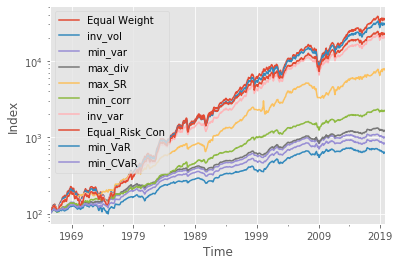

In [0]:
result(Twenty_Five_portfilio_MKT_SMB_HML,2,0.99)

In [0]:
result(Twenty_Five_portfilio_MKT_SMB_HML_UMD,1,0.99)

In [0]:
result(Twenty_Five_portfilio_MKT_SMB_HML_UMD,2,0.99)

In [0]:
result(Twenty_Five_portfilio_MKT_SMB_HML_UMD,3,0.99)

In [0]:
result(Twenty_Five_portfilio_MKT_SMB_HML_UMD,5,0.99)

In [0]:
# Create graphs with different portfolio optimization methods and give you stats
def VaR_result(dataset,Y):
  year = Y
  
  def index(dataset):
    dataset_index = dataset.copy()
    dataset_index.iloc[0] = 100*(dataset.iloc[0]+1)
    for i in range(1,len(dataset_index)) :
      dataset_index.iloc[i]=(dataset_index.iloc[i]+1)*dataset_index.iloc[i-1]
    return dataset_index
  
  beta = [0.99,0.95,0.90,0.85,0.75,0.5]

  for i in range(len(beta)):
    if i ==0:
      result = index(portfolio_optimization(dataset,"min_VaR",year,beta[i]))
    else:
      result[beta[i]]= index(portfolio_optimization(dataset,"min_VaR",year,beta[i]))
  result_plot=result.plot()
  plt.rcParams['axes.prop_cycle']
  plt.yscale('log')
  result_plot.set_xlabel("Time")
  result_plot.set_ylabel("Index")
  plt.savefig('min VaR result')

  def format_float(panda, num):
    new = pd.DataFrame(index = panda.index, columns = panda.columns)
    name = '{:.' + str(num) + 'f}'
    for i in new.index:
        for j in new.columns: new.at[i,j] = name.format(panda.at[i,j])
    return new

  def performance_stats(rets):
    outs = ['Ret%','Std%','DDBMax%','DDBMed%','TuWMax','TuWMed',
            'SR','Skew','Kurt','Corr',
            'hit%','AvgHit%','AvgLos%']
    outs_mat = pd.DataFrame(index=outs, columns=rets.columns)
    ret_pct = rets.pct_change().dropna()
    ret_pct_M = rets.resample('1M').last().pct_change().dropna()
    outs_mat.loc['Ret%',:] = (np.exp(np.log(ret_pct_M + 1.).mean()*12)-1)*100
    outs_mat.loc['Std%',:] = (ret_pct_M.std(ddof=0) * np.sqrt(12)
                              * 100.).replace(0, 0.01)
    DD_flow = rets / rets.cummax()
    outs_mat.loc['DDBMax%',:] = (1.-DD_flow.min())*100.
    outs_mat.loc['DDBMed%',:] = (1.-DD_flow.median())*100.
    DD_count = (DD_flow < (1. - 1e-10)).astype(int)
    DD_range = pd.DataFrame(0, index=rets.index, columns=rets.columns)
    iter_num = len(DD_range) - 1
    for i in range(iter_num):
        prev, now = rets.index[[i,i+1]]
        DD_range.loc[now,:] = (DD_range.loc[prev,:]+1) * DD_count.loc[prev,:]
    outs_mat.loc['TuWMax',:] = DD_range.max() / 21
    outs_mat.loc['TuWMed',:] = DD_range.median() / 21
    outs_mat.loc['SR',:] = outs_mat.loc['Ret%',:] / outs_mat.loc['Std%',:]
    outs_mat.loc['Skew',:] = ret_pct_M.skew()
    outs_mat.loc['Kurt',:] = ret_pct_M.kurt()
    outs_mat.loc['Corr',:] = ret_pct.corr().iloc[-1,:]
    outs_mat.loc['hit%',:] = ((ret_pct_M > 0).sum() / len(ret_pct_M)) * 100.
    outs_mat.loc['AvgHit%',:] = ((ret_pct_M * (ret_pct_M > 0)).sum() /(ret_pct_M > 0).sum()) * 100.
    outs_mat.loc['AvgLos%',:] = ((ret_pct_M * (ret_pct_M < 0)).sum() /(ret_pct_M < 0).sum()) * 100.
    out_put = format_float(outs_mat, 2)
    return out_put

  stats = performance_stats(result)
  print(stats)
  return result_plot 

        Minimum VaR   0.95    0.9   0.85   0.75    0.5
Ret%          13.77  13.55  12.96  12.14   9.75   5.55
Std%          15.81  15.90  16.02  16.18  16.98  21.39
DDBMax%       47.24  47.26  47.27  47.90  51.38  74.78
DDBMed%        1.90   2.05   2.22   2.37   3.57  16.94
TuWMax         2.43   2.38   2.38   2.38   2.52  13.38
TuWMed         0.10   0.10   0.10   0.10   0.14   1.10
SR             0.87   0.85   0.81   0.75   0.57   0.26
Skew          -0.42  -0.39  -0.39  -0.42  -0.52  -0.28
Kurt           5.17   5.43   5.58   5.70   6.01   3.48
Corr           0.85   0.85   0.86   0.87   0.89   1.00
hit%          65.73  65.26  64.95  64.01  62.44  56.65
AvgHit%        3.59   3.60   3.59   3.61   3.65   4.61
AvgLos%       -3.42  -3.40  -3.44  -3.45  -3.66  -4.53


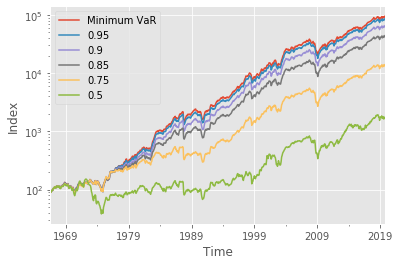

In [0]:
VaR_result(Twenty_Five_portfilio_MKT,3)

In [0]:
# Create graphs with different portfolio optimization methods and give you stats
def CVaR_result(dataset,Y):
  year = Y
  
  def index(dataset):
    dataset_index = dataset.copy()
    dataset_index.iloc[0] = 100*(dataset.iloc[0]+1)
    for i in range(1,len(dataset_index)) :
      dataset_index.iloc[i]=(dataset_index.iloc[i]+1)*dataset_index.iloc[i-1]
    return dataset_index
  
  beta = [0.99,0.95,0.90,0.85,0.75,0.5]

  for i in range(len(beta)):
    if i ==0:
      result = index(portfolio_optimization(dataset,"min_CVaR",year,beta[i]))
    else:
      result[beta[i]]= index(portfolio_optimization(dataset,"min_CVaR",year,beta[i]))
  result_plot=result.plot()
  plt.rcParams['axes.prop_cycle']
  plt.yscale('log')
  result_plot.set_xlabel("Time")
  result_plot.set_ylabel("Index")
  plt.savefig('min CVaR result')

  def format_float(panda, num):
    new = pd.DataFrame(index = panda.index, columns = panda.columns)
    name = '{:.' + str(num) + 'f}'
    for i in new.index:
        for j in new.columns: new.at[i,j] = name.format(panda.at[i,j])
    return new

  def performance_stats(rets):
    outs = ['Ret%','Std%','DDBMax%','DDBMed%','TuWMax','TuWMed',
            'SR','Skew','Kurt','Corr',
            'hit%','AvgHit%','AvgLos%']
    outs_mat = pd.DataFrame(index=outs, columns=rets.columns)
    ret_pct = rets.pct_change().dropna()
    ret_pct_M = rets.resample('1M').last().pct_change().dropna()
    outs_mat.loc['Ret%',:] = (np.exp(np.log(ret_pct_M + 1.).mean()*12)-1)*100
    outs_mat.loc['Std%',:] = (ret_pct_M.std(ddof=0) * np.sqrt(12)
                              * 100.).replace(0, 0.01)
    DD_flow = rets / rets.cummax()
    outs_mat.loc['DDBMax%',:] = (1.-DD_flow.min())*100.
    outs_mat.loc['DDBMed%',:] = (1.-DD_flow.median())*100.
    DD_count = (DD_flow < (1. - 1e-10)).astype(int)
    DD_range = pd.DataFrame(0, index=rets.index, columns=rets.columns)
    iter_num = len(DD_range) - 1
    for i in range(iter_num):
        prev, now = rets.index[[i,i+1]]
        DD_range.loc[now,:] = (DD_range.loc[prev,:]+1) * DD_count.loc[prev,:]
    outs_mat.loc['TuWMax',:] = DD_range.max() / 21
    outs_mat.loc['TuWMed',:] = DD_range.median() / 21
    outs_mat.loc['SR',:] = outs_mat.loc['Ret%',:] / outs_mat.loc['Std%',:]
    outs_mat.loc['Skew',:] = ret_pct_M.skew()
    outs_mat.loc['Kurt',:] = ret_pct_M.kurt()
    outs_mat.loc['Corr',:] = ret_pct.corr().iloc[-1,:]
    outs_mat.loc['hit%',:] = ((ret_pct_M > 0).sum() / len(ret_pct_M)) * 100.
    outs_mat.loc['AvgHit%',:] = ((ret_pct_M * (ret_pct_M > 0)).sum() /(ret_pct_M > 0).sum()) * 100.
    outs_mat.loc['AvgLos%',:] = ((ret_pct_M * (ret_pct_M < 0)).sum() /(ret_pct_M < 0).sum()) * 100.
    out_put = format_float(outs_mat, 2)
    return out_put

  stats = performance_stats(result)
  print(stats)
  return result_plot 

        Minimum CVaR   0.95    0.9   0.85   0.75    0.5
Ret%           13.83  13.82  13.82  13.81  13.77  13.25
Std%           15.79  15.78  15.79  15.80  15.80  15.95
DDBMax%        47.26  47.21  47.34  47.33  47.23  47.10
DDBMed%         1.94   1.95   1.96   2.00   1.89   2.07
TuWMax          2.43   2.43   2.43   2.43   2.43   2.38
TuWMed          0.10   0.10   0.10   0.10   0.10   0.10
SR              0.88   0.88   0.88   0.87   0.87   0.83
Skew           -0.49  -0.47  -0.45  -0.43  -0.41  -0.38
Kurt            5.01   5.04   5.05   5.09   5.12   5.52
Corr            0.99   0.99   1.00   1.00   1.00   1.00
hit%           65.41  65.41  65.57  65.57  65.73  65.57
AvgHit%         3.61   3.61   3.60   3.60   3.59   3.57
AvgLos%        -3.39  -3.38  -3.40  -3.40  -3.42  -3.46


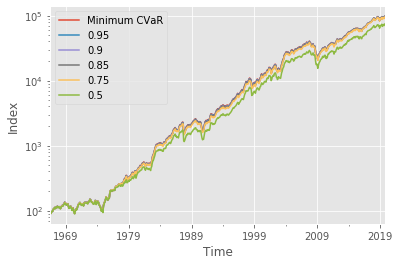

In [0]:
CVaR_result(Twenty_Five_portfilio_MKT,3)

In [0]:
def sampler(dataset,window):
  # In SampleをY年ずつ分ける / Out of Sampleを1か月分ずつ分ける
  Y = window
  M = 12*Y
  dataset_M = dataset.resample('1M').last()
  In_Sample = []
  Out_of_Sample_o =[]
  for i in range(len(dataset_M.index)-M):
    if i==0:
      In_Sample += [dataset.loc[(dataset.index <= dataset_M.index[M-1])]]
      Out_of_Sample_o += [dataset.loc[(dataset.index > dataset_M.index[M+i-1])&(dataset.index <= dataset_M.index[M+i])]]
    else:
      In_Sample += [dataset.loc[(dataset.index > dataset_M.index[i-1])&(dataset.index <= dataset_M.index[M+i-1])]]
      Out_of_Sample_o += [dataset.loc[(dataset.index > dataset_M.index[M+i-1])&(dataset.index <= dataset_M.index[M+i])]]

  #Out-of-Sampleを分ける
  Out_of_Sample = dataset_M[dataset_M.index > dataset_M.index[M-1]]

  #Out-of-Sampleのマンスリー累積リターンを求める
  Out_of_Sample_rets = pd.DataFrame(index=Out_of_Sample.index, columns=Out_of_Sample.columns)
  for i in range(len(Out_of_Sample_rets)):
    Out_of_Sample_rets.iloc[i] = (Out_of_Sample_o[i]+1).prod()-1

  return In_Sample[0], Out_of_Sample_rets

TypeError: ignored

In [0]:
cp.dot(a,b)

7

In [0]:
a = np.array([2,1])
b = np.array([2,3])